Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [ ]:
!pip install hydra-core --upgrade

In [ ]:
from src.commands import *
import hydra

hydra.core.global_hydra.GlobalHydra.instance().clear()
CONF = hydra_config("config (AIM).yaml")
show_CONF(CONF)

{
        "seed": 42,
        "device": "cpu",
        "save_path": "checkpoints",
        "loader": {
                "batch_size": 64
        },
        "siamese": {
                "n_epochs": 100,
                "learning_rate": 0.0003,
                "margin": 9,
                "path_model": "siam_aim",
                "path_log": "siam_aim.pickle"
        },
        "classifier": {
                "n_epochs": 50,
                "learning_rate": 0.0003,
                "path_model": "cl_aim",
                "path_log": "cl_aim.pickle"
        }
}


In [ ]:
show_CONF(CONF)

{
        "seed": 42,
        "device": "cpu",
        "save_path": "checkpoints",
        "loader": {
                "batch_size": 64
        },
        "siamese": {
                "n_epochs": 100,
                "learning_rate": 0.0003,
                "margin": 9,
                "path_model": "siam_aim",
                "path_log": "siam_aim.pickle"
        },
        "classifier": {
                "n_epochs": 50,
                "learning_rate": 0.0003,
                "path_model": "cl_aim",
                "path_log": "cl_aim.pickle"
        }
}


# Библиотеки

In [ ]:
from hydra import compose, initialize
from omegaconf import OmegaConf

import json, os
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from time import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import os, json, cv2, re
import numpy as np
import random

from src.dataset import My_Dataset, TripletDataset, Emb_Dataset
from src.functions import number_of_parameters, seed_everything, create_model
from src.dataset_fun import split_dataset
from src import siamese, classifier
from src.classifier import get_predictions
from src.train import train, load_logs, load_model
from src.functions import confusion_matrix, distribution
from src.show_fun import show_result, show_images

# dataset

In [ ]:
class TripletMultiDataset(Dataset):
    def __init__(self, images_dir, required_len, deterministic=True, seed=42):
        self.images_dir = images_dir
        self.required_len = required_len
        self.deterministic = deterministic

        self.dirs_more_one = []
        self.dirs_other = []

        for dirpath, dirnames, filenames in os.walk(images_dir):

            if len(filenames) > 1:
                self.dirs_more_one.append(dirpath)
            elif len(filenames) == 1:
                self.dirs_other.append(dirpath)

        self.transform = transforms.Compose(
        [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

        if self.deterministic:
            seed_everything(seed)
            self.X = []
            for i in tqdm(range(self.required_len)):

                idx = random.randrange(len(self.dirs_more_one))
                dir = self.dirs_more_one[idx]
                files = os.listdir(dir)

                anchor, positive = random.sample(files, 2)
                anchor, positive = os.path.join(dir, anchor), os.path.join(dir, positive)



                dirs = self.dirs_more_one[:idx] + self.dirs_more_one[idx+1:] + self.dirs_other
                dir = random.choice(dirs)
                files = os.listdir(dir)
                negative = os.path.join(dir, random.choice(files))


                l = [anchor, positive, negative]

                # print(l)
                for i, path in enumerate(l):
                    image = Image.open(path)
                    l[i] = self.transform(image)

                self.X.append(l)


    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                pass
        else:
            raise IndexError

In [ ]:
# torch.save(dataset, 'dataset.pt')

In [ ]:
# tripletdataset = torch.load('dataset.pt')

In [ ]:
# tripletdataset[0][0].shape

In [ ]:
# dataset = datasets.ImageFolder('dataset')
# dataset[1000], len(dataset)

In [ ]:
# d = {}

# i = 0
# for num in sorted(os.listdir('dataset')):
#     num = int(num)
#     d[num] = i
#     i+=1

In [ ]:
# d[57]

In [ ]:
# dataset = datasets.ImageFolder('dataset', target_transform = lambda x: d[x])
# dataset[1000], len(dataset)

In [ ]:
# len(os.listdir('dataset'))

# train

In [ ]:
siam = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_classes = 1000
num_non_freeze = 11689512
seed_everything(CONF.seed)
siam = create_model(siam, num_non_freeze, num_classes).to(CONF.device)
print(f"num parameters ResNet = {number_of_parameters(siam)}")

# tripletdataset = TripletMultiDataset("dataset", required_len=1000)
# torch.save(dataset, 'dataset.pt')
seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(tripletdataset)

common_train(CONF, siam, train_dataset, test_dataset, kind="siam")
load_best_model(CONF, siam, train_dataset, test_dataset, kind="siam")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


num parameters ResNet = 11689512
split_dataset: Train: 800 Test: 200 Total: 1000
train: started, kind = 'siam'
# 2024-05-31 12:31:31 Epoch   1 train/val: loss 1.51179/2.73268, acc: 95.625%/ 89.000%
# 2024-05-31 12:31:42 Epoch   2 train/val: loss 0.75013/1.88075, acc: 98.125%/ 95.000%
# 2024-05-31 12:31:53 Epoch   3 train/val: loss 0.14425/1.45785, acc: 99.750%/ 95.500%
# 2024-05-31 12:32:04 Epoch   4 train/val: loss 0.09025/1.84709, acc: 99.750%/ 93.500%
# 2024-05-31 12:32:15 Epoch   5 train/val: loss 0.07515/1.49996, acc:100.000%/ 94.000%
# 2024-05-31 12:32:26 Epoch   6 train/val: loss 0.03575/1.46413, acc:100.000%/ 96.000%
# 2024-05-31 12:32:37 Epoch   7 train/val: loss 0.06482/1.38493, acc: 99.875%/ 96.000%
# 2024-05-31 12:32:48 Epoch   8 train/val: loss 0.03719/0.80462, acc: 99.875%/ 97.500%
# 2024-05-31 12:32:59 Epoch   9 train/val: loss 0.09224/0.76207, acc: 99.750%/ 96.500%
# 2024-05-31 12:33:10 Epoch  10 train/val: loss 0.14133/1.80123, acc: 99.625%/ 93.000%
# 2024-05-31 12:33:

In [ ]:
class Emb_Dataset(Dataset):
    def __init__(self, model, dataset, device):
        self.dataset = dataset
        self.model = model.eval()
        self.device = device

        self.transform = transforms.Compose(
        [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

        self.X = []

        for img, cls in tqdm(self.dataset):
            img = self.transform(img)
            # emb = self.model(img[None, :].to(self.device))[0]
            emb = torch.ones(1000)
            self.X.append((emb.cpu(), cls))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if idx < len(self):
            return self.X[idx]
        else:
            raise IndexError


In [ ]:
# for img, cls in dataset:
#     print(img, cls)

In [ ]:
# !pip install GPUtil

# import torch
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda

# def free_gpu_cache():
#     print("Initial GPU Usage")
#     gpu_usage()

#     torch.cuda.empty_cache()

#     cuda.select_device(0)
#     cuda.close()
#     cuda.select_device(0)

#     print("GPU Usage after emptying the cache")
#     gpu_usage()

# free_gpu_cache()

In [ ]:
siam = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# common_train(CONF, siam, train_dataset, test_dataset, kind="siam")
load_best_model(CONF, siam, None, None, kind="siam")

load_best_model:
LOGS:
# 2024-05-31 18:54:12 Epoch  98 train/val: loss 0.01309/0.67211, acc:100.000%/ 98.000%


In [ ]:
dataset = datasets.ImageFolder('dataset', transform=transforms.Compose(
        [
            transforms.RandomCrop(300),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]))

In [ ]:
dataloader = DataLoader(dataset, batch_size=CONF.loader.batch_size, shuffle=False)
pred_items = []
true_items = []

with torch.no_grad():
    for batch in tqdm(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch

        true_items.append(y_batch)
        logits = siam(X_batch.to(CONF.device))

        pred_items.append(logits)

pred_items = torch.cat(pred_items)
true_items = torch.cat(true_items)

100%|██████████| 25/25 [14:13<00:00, 34.13s/it]


In [ ]:
torch.save(pred_items, 'pred_items.pt')
torch.save(true_items, 'true_items.pt')

In [ ]:
pred_items = torch.load('pred_items.pt')
true_items = torch.load('true_items.pt')

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X_train = pred_items.cpu().numpy()
y_train = true_items.cpu().numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=0.2, random_state=42)

seed_everything(CONF.seed)

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)

clf.score(X_train, y_train), clf.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X_train = pred_items.cpu().numpy()
y_train = true_items.cpu().numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=0.2, random_state=42)

seed_everything(CONF.seed)

clf = GradientBoostingClassifier(random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

In [ ]:
!pip install catboost

from catboost import CatBoostClassifier

X_train = pred_items.cpu().numpy()
y_train = true_items.cpu().numpy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=0.2, random_state=42)

seed_everything(CONF.seed)

clf = CatBoostClassifier(iterations=10, random_state=0).fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

Learning rate set to 0.5
0:	learn: 6.0714641	total: 4m 22s	remaining: 39m 25s
1:	learn: 5.7575440	total: 8m 27s	remaining: 33m 49s
2:	learn: 5.4589626	total: 12m 52s	remaining: 30m 1s
3:	learn: 5.1820389	total: 17m 1s	remaining: 25m 32s
4:	learn: 4.9338695	total: 21m 22s	remaining: 21m 22s
5:	learn: 4.6933255	total: 25m 32s	remaining: 17m 1s
6:	learn: 4.4804731	total: 29m 43s	remaining: 12m 44s
7:	learn: 4.2799682	total: 34m 8s	remaining: 8m 32s
8:	learn: 4.0794776	total: 38m 15s	remaining: 4m 15s
9:	learn: 3.8926165	total: 42m 37s	remaining: 0us


(0.2867587327376117, 0.13636363636363635)

In [ ]:
clf.save_model('CatBoostClassifier')

In [ ]:
clf.load_model('CatBoostClassifier')

In [ ]:
y_train.shape

(1539, 1000)

In [ ]:
class Emb_Dataset(Dataset):
    def __init__(self, prob_items, true_items):
        self.prob_items = prob_items
        self.true_items = true_items

    def __len__(self):
        return len(self.prob_items)

    def __getitem__(self, idx):
        if idx < len(self):
            return self.prob_items[idx], self.true_items[idx]
        else:
            raise IndexError

In [ ]:
cl = nn.Sequential(nn.Linear(1000, 512),
                   nn.ReLU(),
                   nn.Linear(512, 657),
                   ).to(
    CONF.device
)
num_param = number_of_parameters(cl)
print(f"num parameters = {num_param}")

dataset = datasets.ImageFolder('dataset')
emb_dataset = Emb_Dataset(pred_items, true_items)
torch.save(dataset, 'emb_dataset.pt')
# emb_dataset = torch.load('emb_dataset.pt')

seed_everything(CONF.seed)
train_dataset, test_dataset = split_dataset(emb_dataset)

common_train(CONF, cl, train_dataset, test_dataset, kind="cl")
load_best_model(CONF, cl, train_dataset, test_dataset, kind="cl")

num parameters = 849553
split_dataset: Train: 1231 Test: 308 Total: 1539
train: started, kind = 'cl'
# 2024-05-31 18:01:04 Epoch  1 train/val: loss 4.78649/5.78124, acc: 16.572%/ 10.390%
# 2024-05-31 18:01:05 Epoch  2 train/val: loss 3.69425/5.67635, acc: 26.645%/ 15.260%
# 2024-05-31 18:01:05 Epoch  3 train/val: loss 2.97323/5.69128, acc: 35.175%/ 23.052%
# 2024-05-31 18:01:05 Epoch  4 train/val: loss 2.45238/5.86743, acc: 42.648%/ 26.948%
# 2024-05-31 18:01:05 Epoch  5 train/val: loss 2.07636/6.06084, acc: 46.385%/ 25.974%
# 2024-05-31 18:01:05 Epoch  6 train/val: loss 1.77666/6.24929, acc: 54.102%/ 30.519%
# 2024-05-31 18:01:05 Epoch  7 train/val: loss 1.52953/6.52770, acc: 59.951%/ 32.792%
# 2024-05-31 18:01:05 Epoch  8 train/val: loss 1.34918/6.79059, acc: 64.663%/ 33.442%
# 2024-05-31 18:01:05 Epoch  9 train/val: loss 1.20182/6.96984, acc: 69.943%/ 31.169%
# 2024-05-31 18:01:05 Epoch 10 train/val: loss 1.06680/7.20323, acc: 73.355%/ 31.818%
# 2024-05-31 18:01:05 Epoch 11 train/va

In [ ]:
def graph2(x, y1, y2, title="", ylog=True):
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=13)

    plt.plot(x, y1, color='g', label = "Train")
    plt.plot(x, y2, color='m', label = "Test")

    plt.grid(True)
    plt.ylabel("loss",  fontsize=10)
    plt.xlabel("Номер итерации",  fontsize=10)

    if ylog:
        plt.yscale('log')

    plt.legend(fontsize=10)

    plt.show()

In [ ]:
# graph2(logs['epoch'], logs['train_loss'], logs['val_loss'], title="")

In [ ]:
# graph2(logs['epoch'], logs['train_accuracy'], logs['val_accuracy'], ylog = False)

# eval

In [ ]:
class Pipeline(nn.Module):
    def __init__(self, model, cl):
        super().__init__()
        self.model = model
        self.cl = cl

    def forward(self, x):
        x = self.model(x.to(CONF.device))
        x = self.cl(x)
        return x

model = Pipeline(siam, cl)

0.9648760330578512


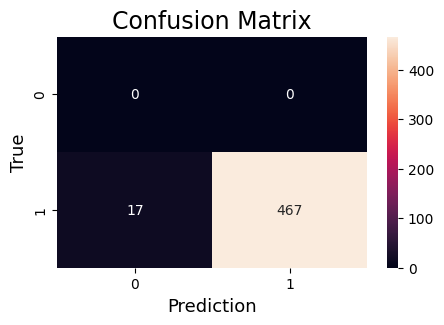

[[  0   0]
 [ 17 467]]


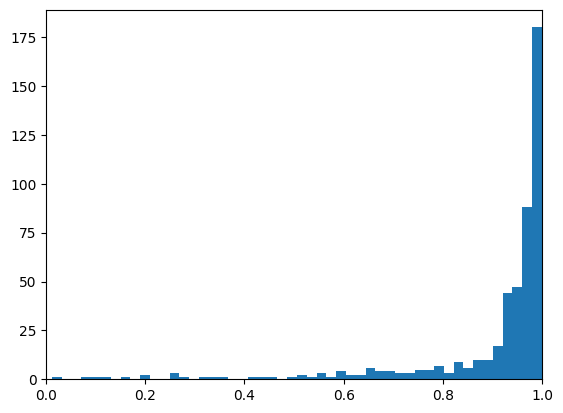

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, pos_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.987603305785124
# array([[  0,   0],
#        [  6, 478]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.9575892857142857


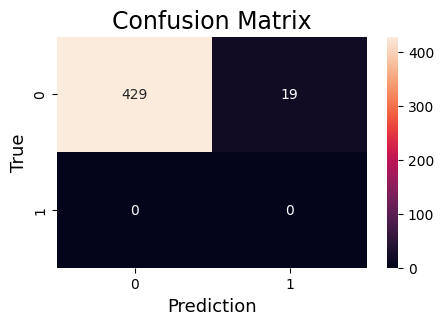

[[429  19]
 [  0   0]]


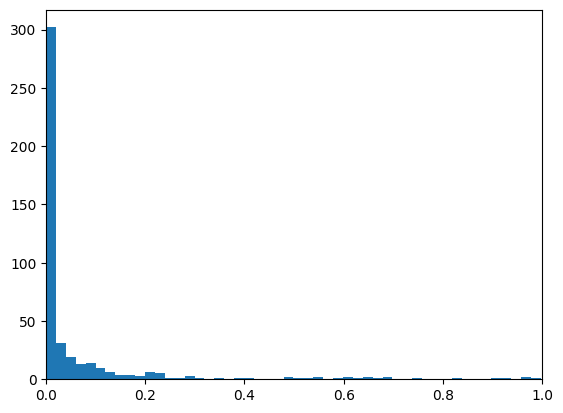

In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, neg_dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
# 0.96875
# array([[435,  13],
#        [  0,   0]])
print(confusion_matrix(y_true, y_pred))
distribution(y_prob)

0.9613733905579399


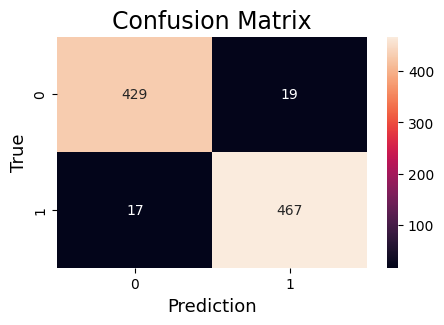

[[429  19]
 [ 17 467]]


In [ ]:
X, y_true, y_pred, y_prob = get_predictions(model, dataset,
                                            CONF.loader.batch_size, CONF.device)
print(accuracy_score(y_pred, y_true))
print(confusion_matrix(y_true, y_pred))
# 0.9785407725321889
# array([[435,  13],
#        [  6, 478]])

# show

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0.6,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = False, col = 30,
                                   sort = True)

prob > 0.4
count : 23 out of 448
pic idx : [167, 426, 277, 137, 215, 127, 64, 388, 129, 194, 20, 46, 230, 53, 49, 352, 210, 270, 113, 29, 226, 13, 276]


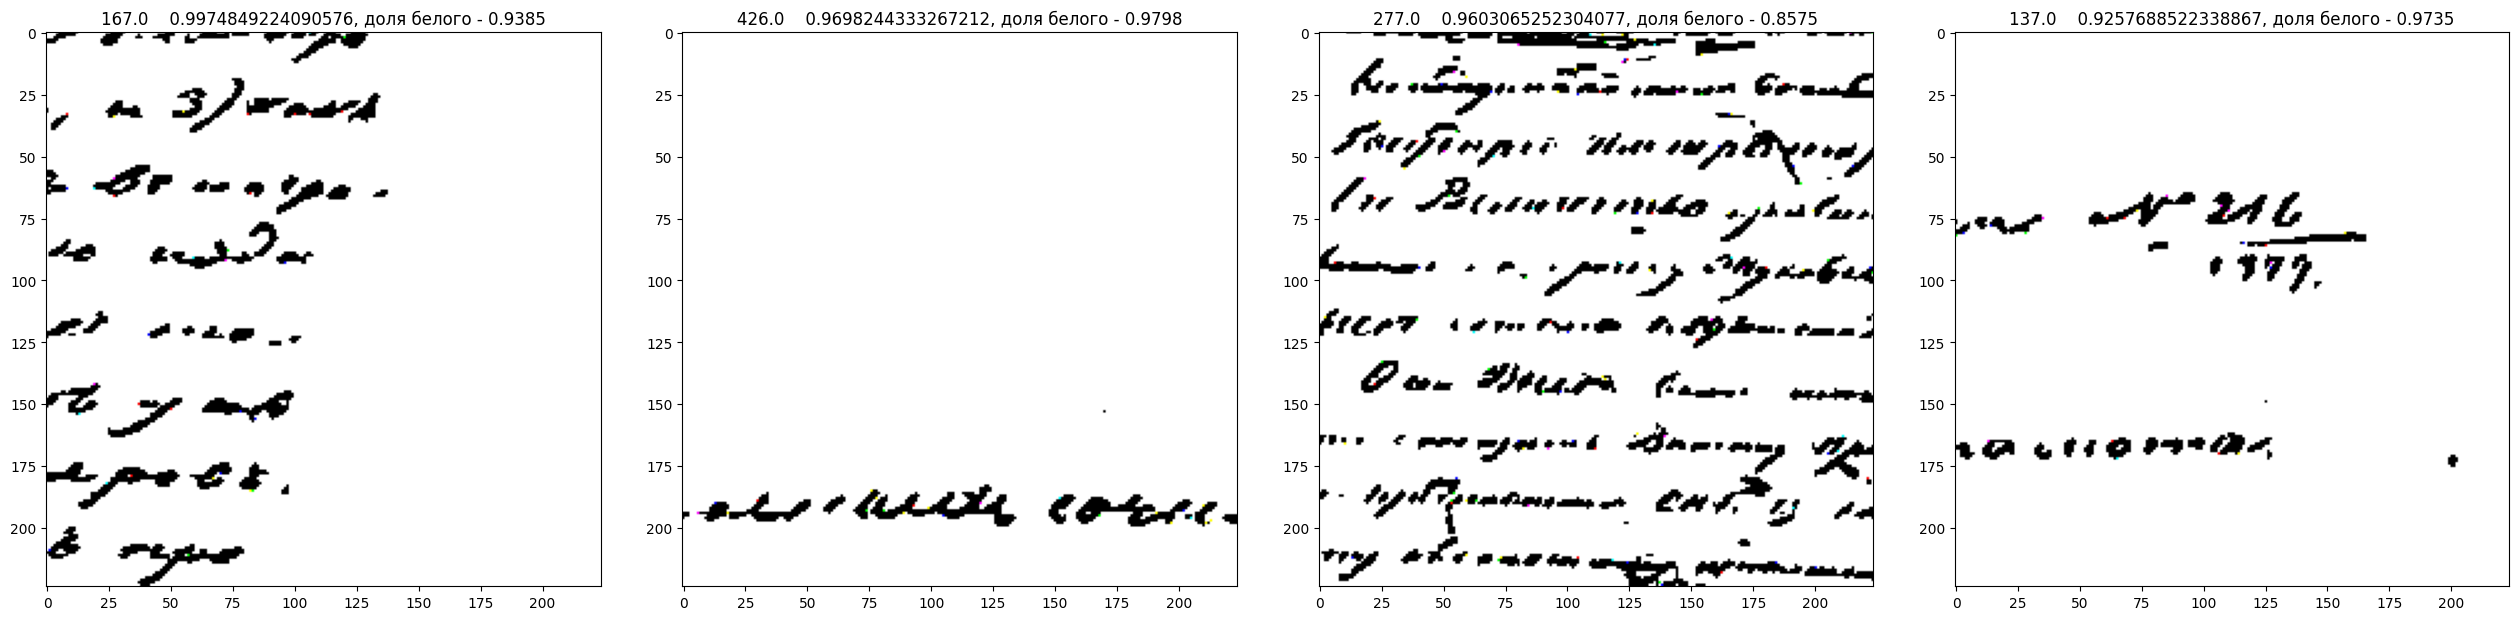

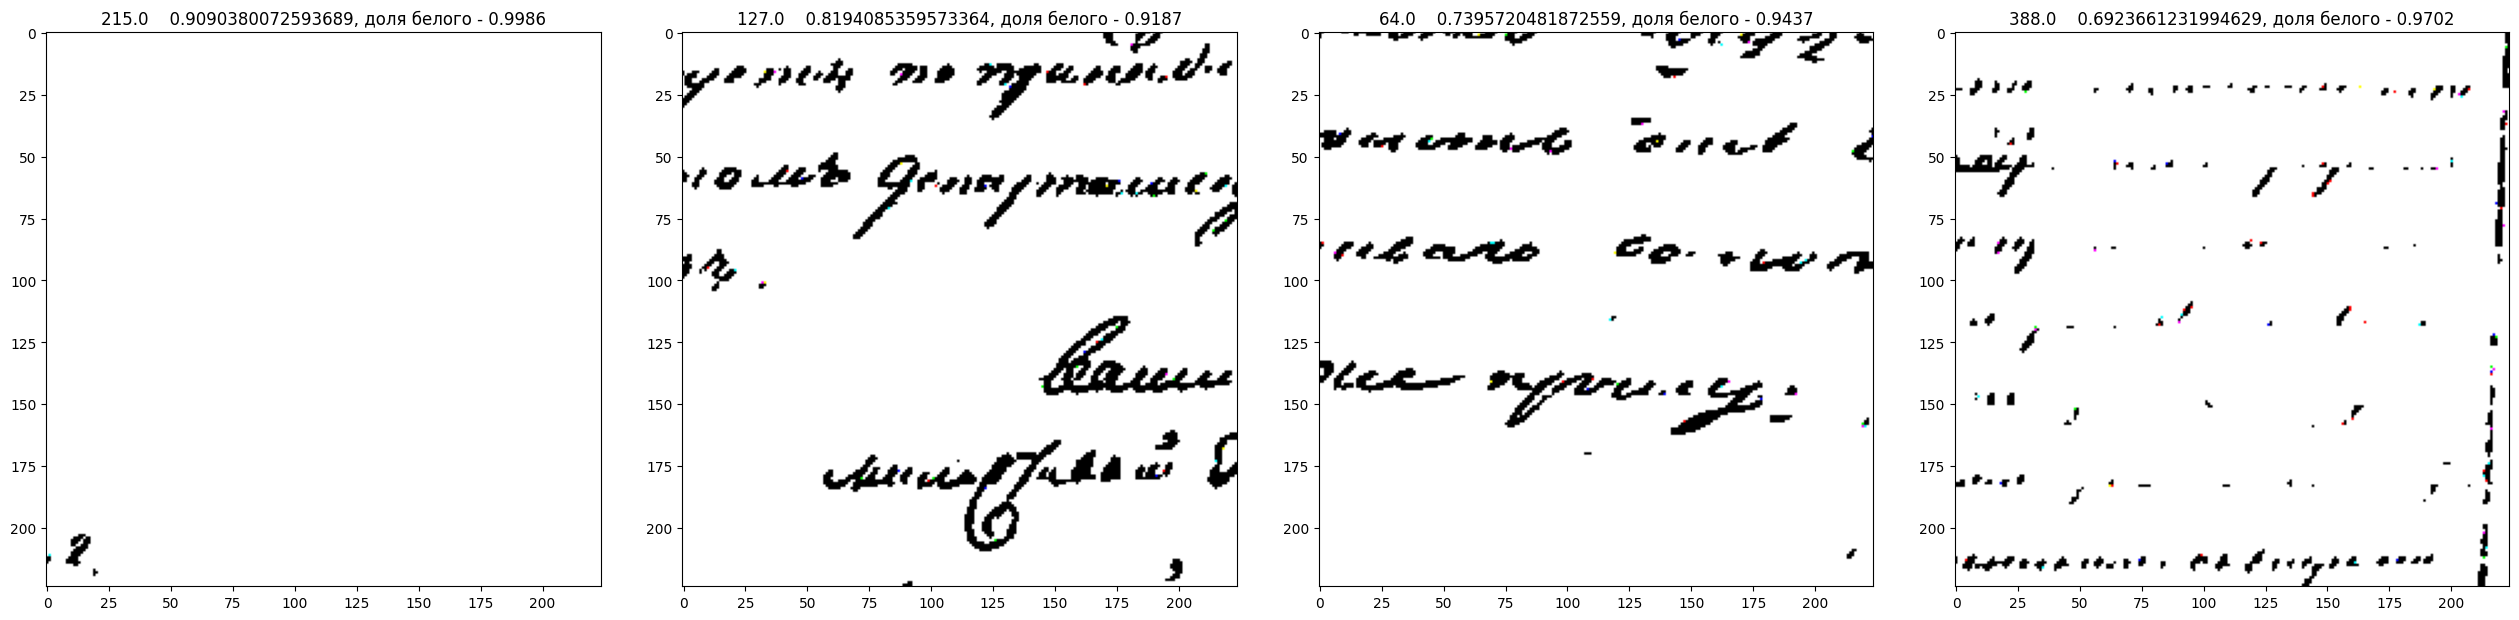

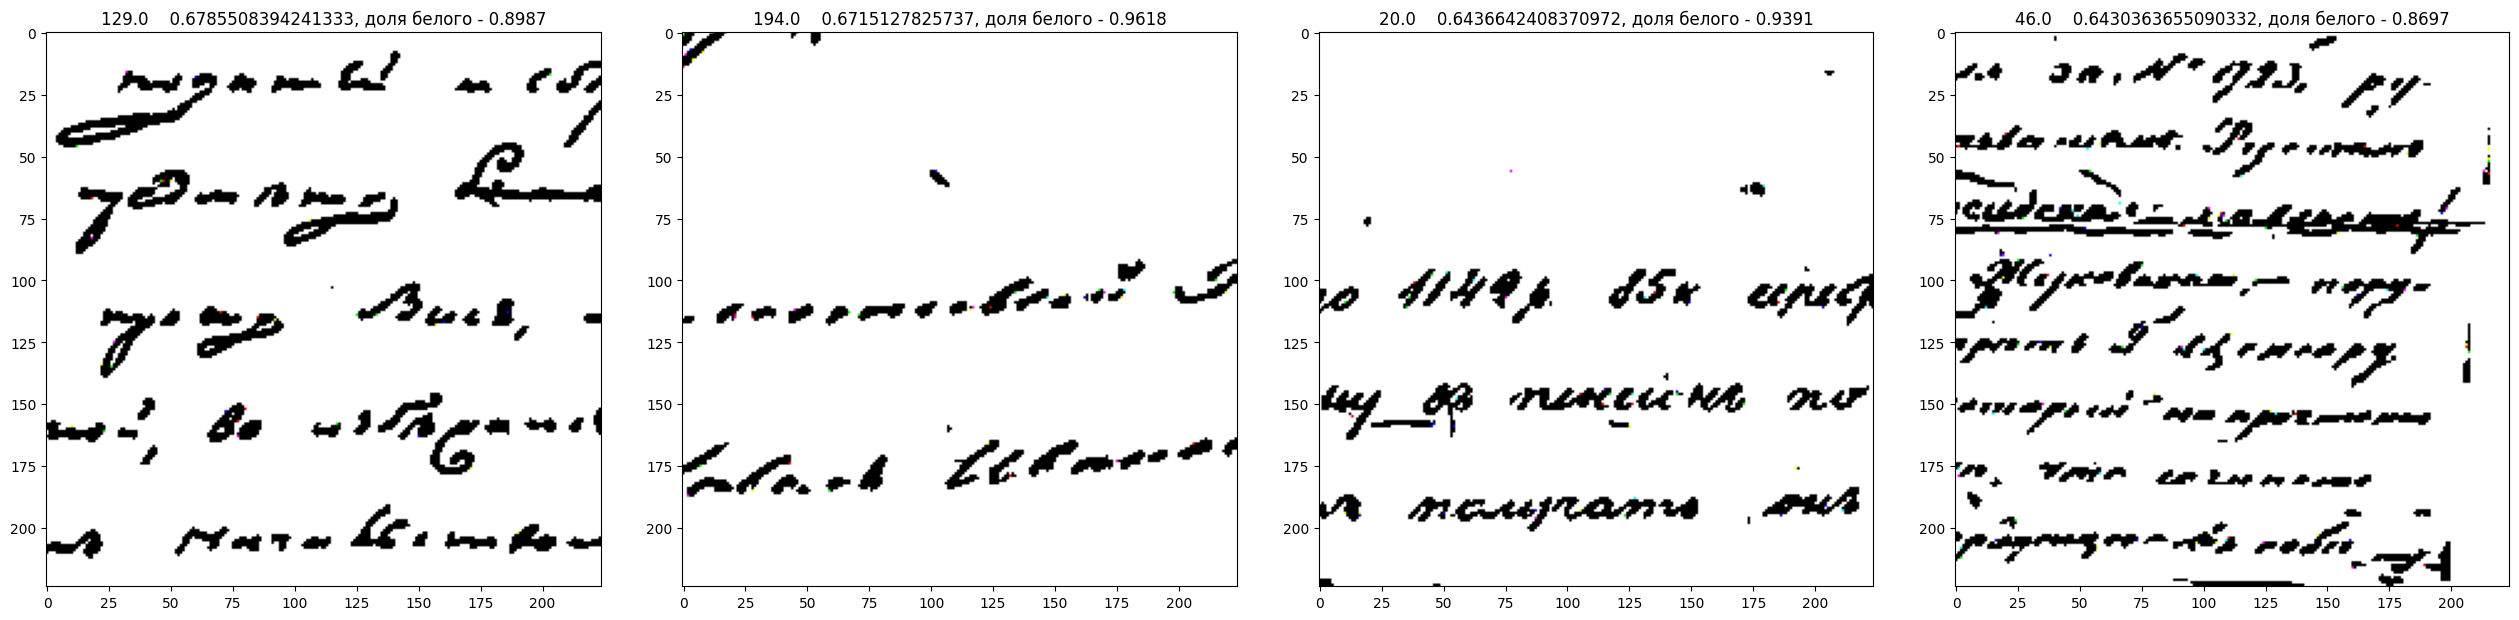

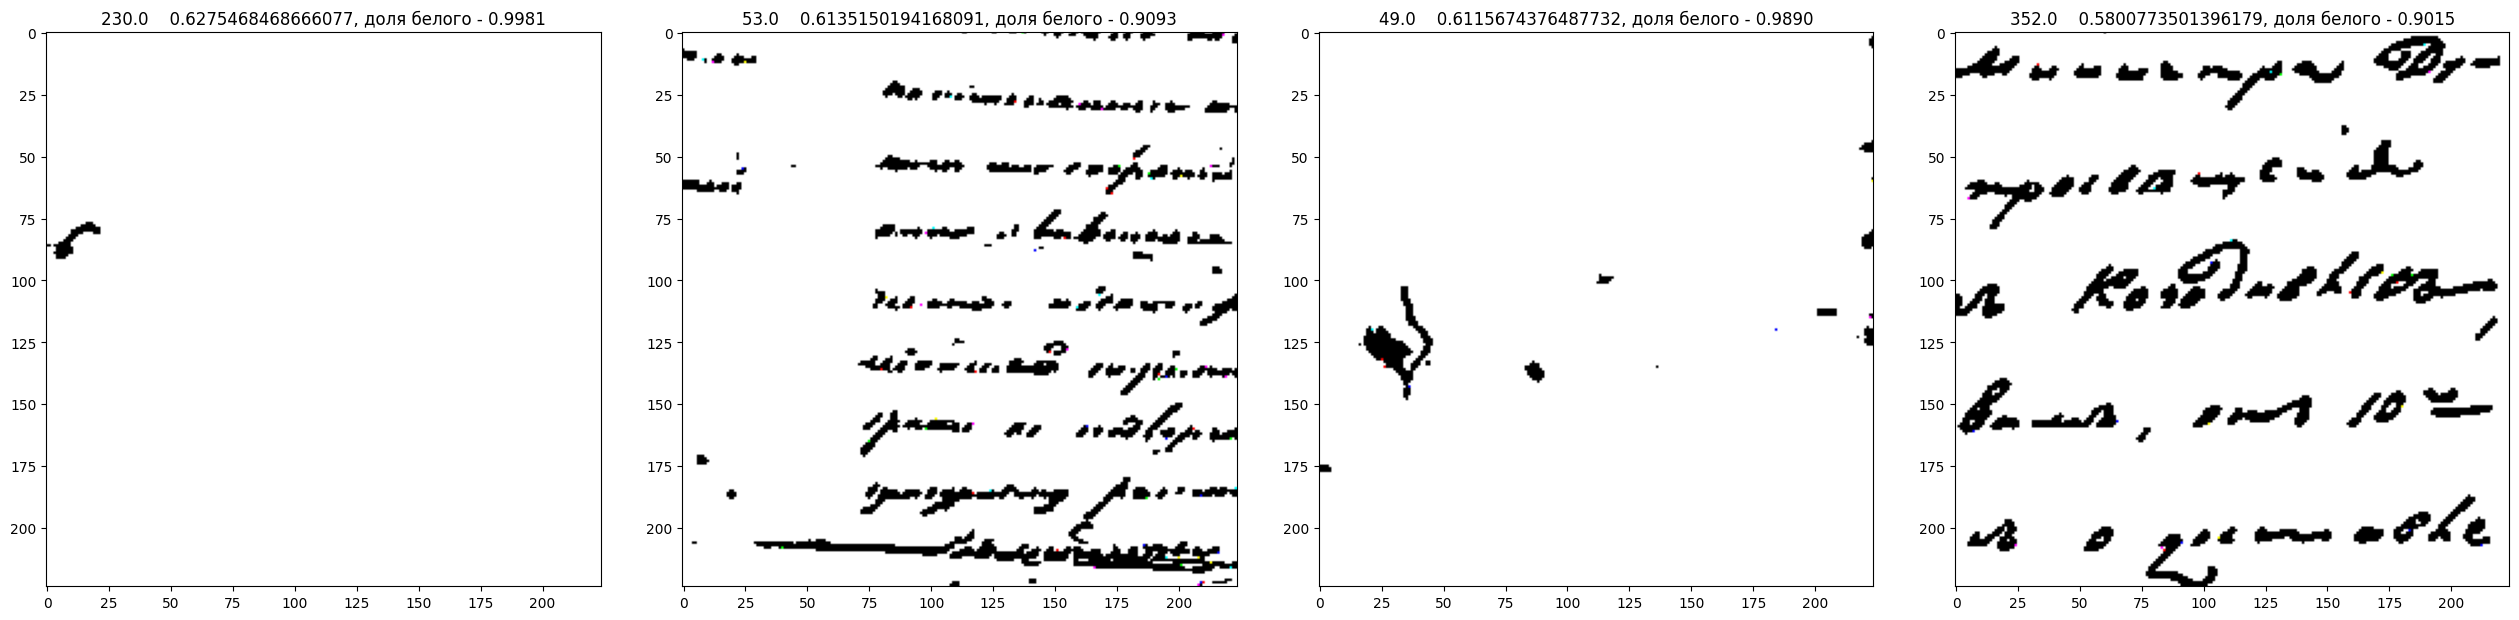

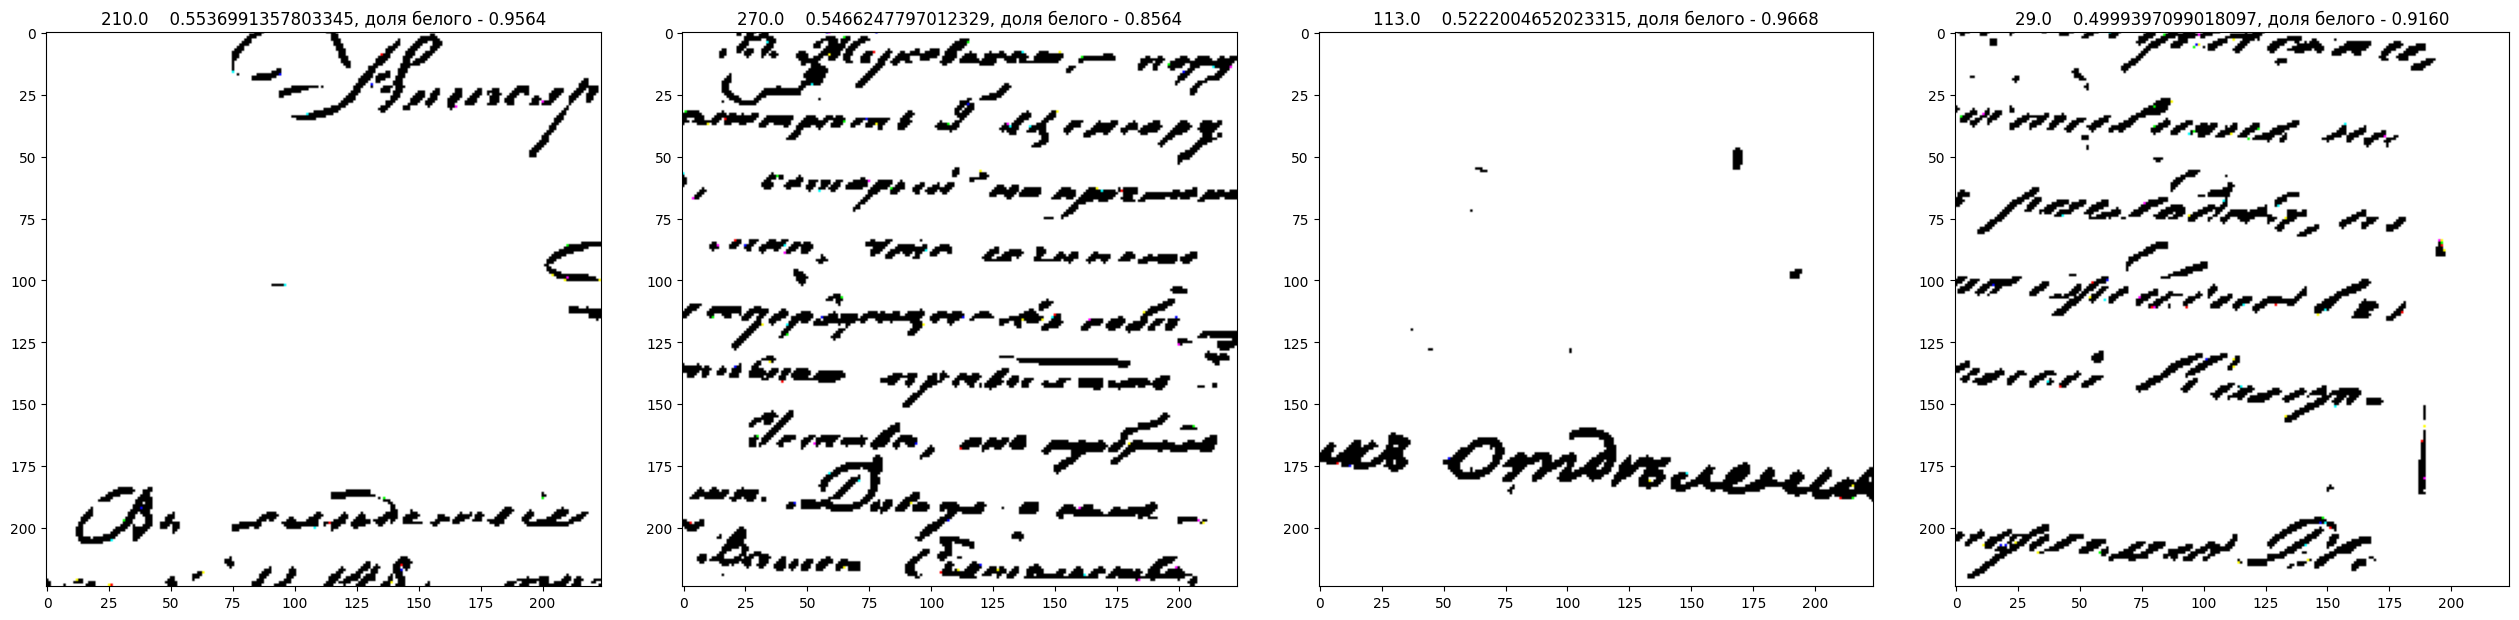

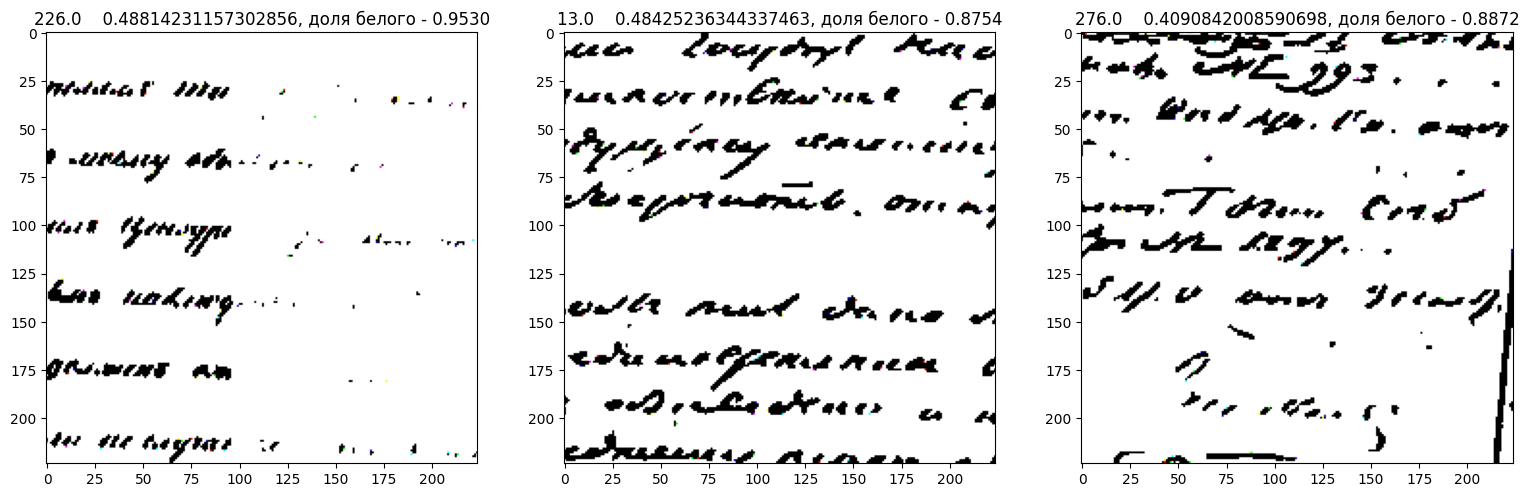

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0.4,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 24,
                                   sort = True)

# on the entire dataset

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, neg_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 448,
                                   sort = True)

In [ ]:
X, y_true, y_pred, y_prob, indices = show_result(model, pos_dataset, 0,
                                   CONF.loader.batch_size, CONF.device,
                                   greater = True, col = 484,
                                   sort = True)